In [41]:
from os import makedirs, listdir
from random import seed, random
from shutil import copyfile

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from keras.applications import EfficientNetB0
from keras.callbacks import ReduceLROnPlateau
from keras import layers
from matplotlib.image import imread
from tensorflow.python.data import Dataset

print(f'TF version: {tf.__version__}')

TF version: 2.9.2


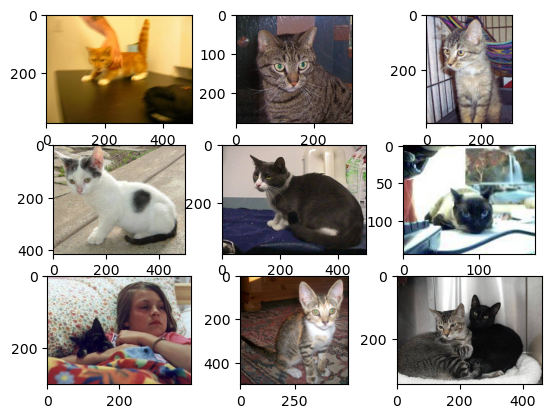

In [42]:
folder = 'data/pictures/dogs-vs-cats/train/'
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = folder + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
plt.show()

In [43]:
# create directories
# dataset_home = 'data/pictures/dataset_dogs_vs_cats/'
# subdirs = ['train/', 'test/']
# for subdir in subdirs:
# 	# create label subdirectories
# 	labeldirs = ['dogs/', 'cats/']
# 	for labldir in labeldirs:
# 		newdir = dataset_home + subdir + labldir
# 		makedirs(newdir, exist_ok=True)

In [44]:
# # seed random number generator
# seed(1)
# # define ratio of pictures to use for validation
# val_ratio = 0.25
# define image size
img_size = 224
# # copy training dataset images into subdirectories
# src_directory = 'data/pictures/dogs-vs-cats/train/'
# for file in listdir(src_directory):
# 	src = src_directory + '/' + file
# 	dst_dir = 'train/'
# 	if random() < val_ratio:
# 		dst_dir = 'test/'
# 	if file.startswith('cat'):
# 		dst = dataset_home + dst_dir + 'cats/'  + file
# 		copyfile(src, dst)
# 	elif file.startswith('dog'):
# 		dst = dataset_home + dst_dir + 'dogs/'  + file
# 		copyfile(src, dst)

In [45]:
train_path_cats = 'data/pictures/dataset_dogs_vs_cats/train/cats'
train_path_dogs = 'data/pictures/dataset_dogs_vs_cats/train/dogs'
# Correct for class imbalance
total = len(listdir(train_path_cats)) + len(listdir(train_path_dogs))
cats = len(listdir(train_path_cats))
dogs = len(listdir(train_path_dogs))

weight_cats = 1 / cats * (total / 2.0)
weight_dogs = 1 / dogs * (total / 2.0)

class_weight = {0: weight_cats, 1: weight_dogs}
class_weight

{0: 1.0017681097299613, 1: 0.9982381206620395}

In [46]:
test: Dataset = tf.keras.utils.image_dataset_from_directory(
	directory='data/pictures/dataset_dogs_vs_cats/test',
	batch_size=64,
	image_size=(img_size,img_size)
)
train: Dataset = tf.keras.utils.image_dataset_from_directory(
	directory='data/pictures/dataset_dogs_vs_cats/train',
	batch_size=64,
	image_size=(img_size,img_size),
	validation_split=0.25,
	subset='training',
	seed=1
)
val: Dataset = tf.keras.utils.image_dataset_from_directory(
	directory='data/pictures/dataset_dogs_vs_cats/train',
	batch_size=64,
	image_size=(img_size,img_size),
	validation_split=0.25,
	subset='validation',
	seed=1
)

Found 6303 files belonging to 2 classes.
Found 18697 files belonging to 2 classes.
Using 14023 files for training.
Found 18697 files belonging to 2 classes.
Using 4674 files for validation.


In [47]:
base_model = EfficientNetB0(
	weights='imagenet',
	input_shape=(img_size,img_size,3),
	include_top=False,
)
base_model.trainable = False

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x164ecfd30>
Traceback (most recent call last):
  File "/Users/adam/miniforge3/envs/agricam/lib/python3.9/site-packages/tensorflow/python/eager/function.py", line 304, in __del__
    context.remove_function(self.name)
  File "/Users/adam/miniforge3/envs/agricam/lib/python3.9/site-packages/tensorflow/python/eager/context.py", line 2719, in remove_function
    context().remove_function(name)
  File "/Users/adam/miniforge3/envs/agricam/lib/python3.9/site-packages/tensorflow/python/eager/context.py", line 1368, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
KeyboardInterrupt: 


In [48]:
def get_pretrained():
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))

    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=output)

    return model

In [49]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                           

In [50]:
batch_size = 32
n_epochs = 25

learning_rate_reduction = ReduceLROnPlateau(monitor='val_binary_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# with tf.device('/gpu:0'):
history_tl = model_pretrained.fit(
    train,
    epochs = n_epochs,
    callbacks = [learning_rate_reduction],
    steps_per_epoch = train.cardinality().numpy()/batch_size,
    validation_data = val,
    class_weight = class_weight
)

Epoch 1/25


2022-09-09 17:13:59.313962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/6 [==============================] - ETA: 0s - loss: 0.7408 - binary_accuracy: 0.4241

2022-09-09 17:14:10.581991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 92s 14s/step - loss: 0.7408 - binary_accuracy: 0.4241 - val_loss: 0.6565 - val_binary_accuracy: 0.5996 - lr: 5.0000e-05
Epoch 2/25
6/6 [==============================] - 101s 17s/step - loss: 0.6204 - binary_accuracy: 0.6897 - val_loss: 0.5683 - val_binary_accuracy: 0.8070 - lr: 5.0000e-05
Epoch 3/25
7/6 [==============================] - ETA: 0s - loss: 0.5467 - binary_accuracy: 0.8125

KeyboardInterrupt: 

In [ ]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
losses[['binary_accuracy','val_binary_accuracy']].plot()

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(test)[1]*100 , "%")

## Fine-tuning

In [ ]:
base_model.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [ ]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics='binary_accuracy')

model_pretrained.summary()

In [ ]:
history_tl = model_pretrained.fit(
                    train,
                    epochs = n_epochs,
                    callbacks = [learning_rate_reduction],
					steps_per_epoch = train.cardinality().numpy()/batch_size,
					validation_data = val,
                    class_weight = class_weight
                   )

#### 3.1.4. Results

Test loss & accuracy

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(test)[1]*100 , "%")